This notebook reports how many hours members spent off the board. It provides a table representation of the data as well as a visual heat map representation


In [1]:
from __future__ import absolute_import, division, print_function
from multiprocessing import Pool

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../../src/data/')

from config import *

In [3]:
#Dates that will be relevant
PERIOD_1 = ['2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17',
'2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', 
'2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29']
PERIOD_2 = ['2018-07-30', '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04', 
'2018-08-05', '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10', 
'2018-08-11', '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15']

ALL_DATES = PERIOD_1 + PERIOD_2

WEEKENDS = ['2018-06-16', '2018-06-17', '2018-06-23', '2018-06-24']

In [4]:
#Preparing the members and beacons metadata
members_metadata = pd.read_csv(members_metadata_path).set_index('member')
beacons_metadata = pd.read_csv(beacons_metadata_path).set_index('beacon')

Small Functions that help filter the data:

In [5]:
def get_closest_beacon(m5cb, members_metadata, beacons_metadata):
    """
    Parameters: dataframe, dataframe, dataframe
    Returns: a table with the closest beacon for each member
    """
    
    #Create table with only closest beacon
    m1cb = m5cb[['beacon_0', 'rssi_0']].rename(
        columns = {'beacon_0': 'beacon', 'rssi_0': 'rssi'}).reset_index()

    #Add beacon metadata
    m1cb = m1cb.join(
            beacons_metadata[['company', 'type']], on='beacon').rename(
            columns = {'company': 'beacon_company', 'type': 'beacon_type'})
    #Add badge metadata
    m1cb = m1cb.join(
            members_metadata[['company']], on='member').rename(columns = {'company': 'member_company'})
    
    return m1cb

In [6]:
def drop_board_beacons(mySeries):
    """
    Given a dataframe
    Returns a dataframe without board beacons
    """
    return mySeries[mySeries.beacon_type != 'board']

In [7]:
def on_board(mySeries):
    """
    Given a dataframe
    Returns an additional column of booleans
        True if beacon type is board
        False otherwise
    """
    return mySeries['beacon_type'] == 'board'

In [8]:
def count_to_hours(counter):
    """
    Given a count
    Returns hours
    """
    seconds = counter*15
    minutes = seconds/60
    hours = minutes/60
    return(round(hours,2))

Generating a dataframe of hours off the board for the entirety of period one:

In [9]:
members_metadata_copy = members_metadata.reset_index()
hours_off_board_period_one = pd.DataFrame(index = members_metadata_copy['member'])

for date in PERIOD_1:
    tempHours = pd.DataFrame()
    
    day_start = date + ' 00:00:00-04:00'
    day_end = date + ' 23:59:30-04:00'
    desired_range = "datetime >= day_start & datetime < day_end"
    
    m5cb = pd.read_hdf(clean_store_path,'proximity/member_5_closest_beacons', where = desired_range, data_columns= True)
    
    m1cb_with_boards = get_closest_beacon(m5cb, members_metadata, beacons_metadata)
    m1cb_with_boards['on_board'] = on_board(m1cb_with_boards)
    
    grouped_with_boards = m1cb_with_boards.groupby(['member', 'on_board'])

    counts_with_boards = grouped_with_boards['on_board'].count()
    counts_with_boards = counts_with_boards.unstack()

    tempHours[date] = counts_with_boards[False].apply(count_to_hours)

    hours_off_board_period_one = hours_off_board_period_one.join(tempHours)
    


Generating a dataframe of hours off the board for the entirety of period two

In [10]:
members_metadata_copy = members_metadata.reset_index()
hours_off_board_period_two = pd.DataFrame(index = members_metadata_copy['member'])

for date in PERIOD_2:
    tempHours = pd.DataFrame()
    
    day_start = date + ' 00:00:00-04:00'
    day_end = date + ' 23:59:30-04:00'
    desired_range = "datetime >= day_start & datetime < day_end"
    
    m5cb = pd.read_hdf(clean_store_path,'proximity/member_5_closest_beacons', where = desired_range, data_columns= True)
    
    m1cb_with_boards = get_closest_beacon(m5cb, members_metadata, beacons_metadata)
    m1cb_with_boards['on_board'] = on_board(m1cb_with_boards)
    
    grouped_with_boards = m1cb_with_boards.groupby(['member', 'on_board'])

    counts_with_boards = grouped_with_boards['on_board'].count()
    counts_with_boards = counts_with_boards.unstack()

    tempHours[date] = counts_with_boards[False].apply(count_to_hours)

    hours_off_board_period_two = hours_off_board_period_two.join(tempHours)
    

In [11]:
#Cleaning the tables
hours_off_board_period_one = hours_off_board_period_one.fillna(0)
hours_off_board_period_two = hours_off_board_period_two.fillna(0)
hours_off_board_period_one.sort_index(inplace = True)
hours_off_board_period_two.sort_index(inplace = True)

2018-12-14 09:53:42,584 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/orenled/Envs/rhythm-private-analysis-deltav17/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


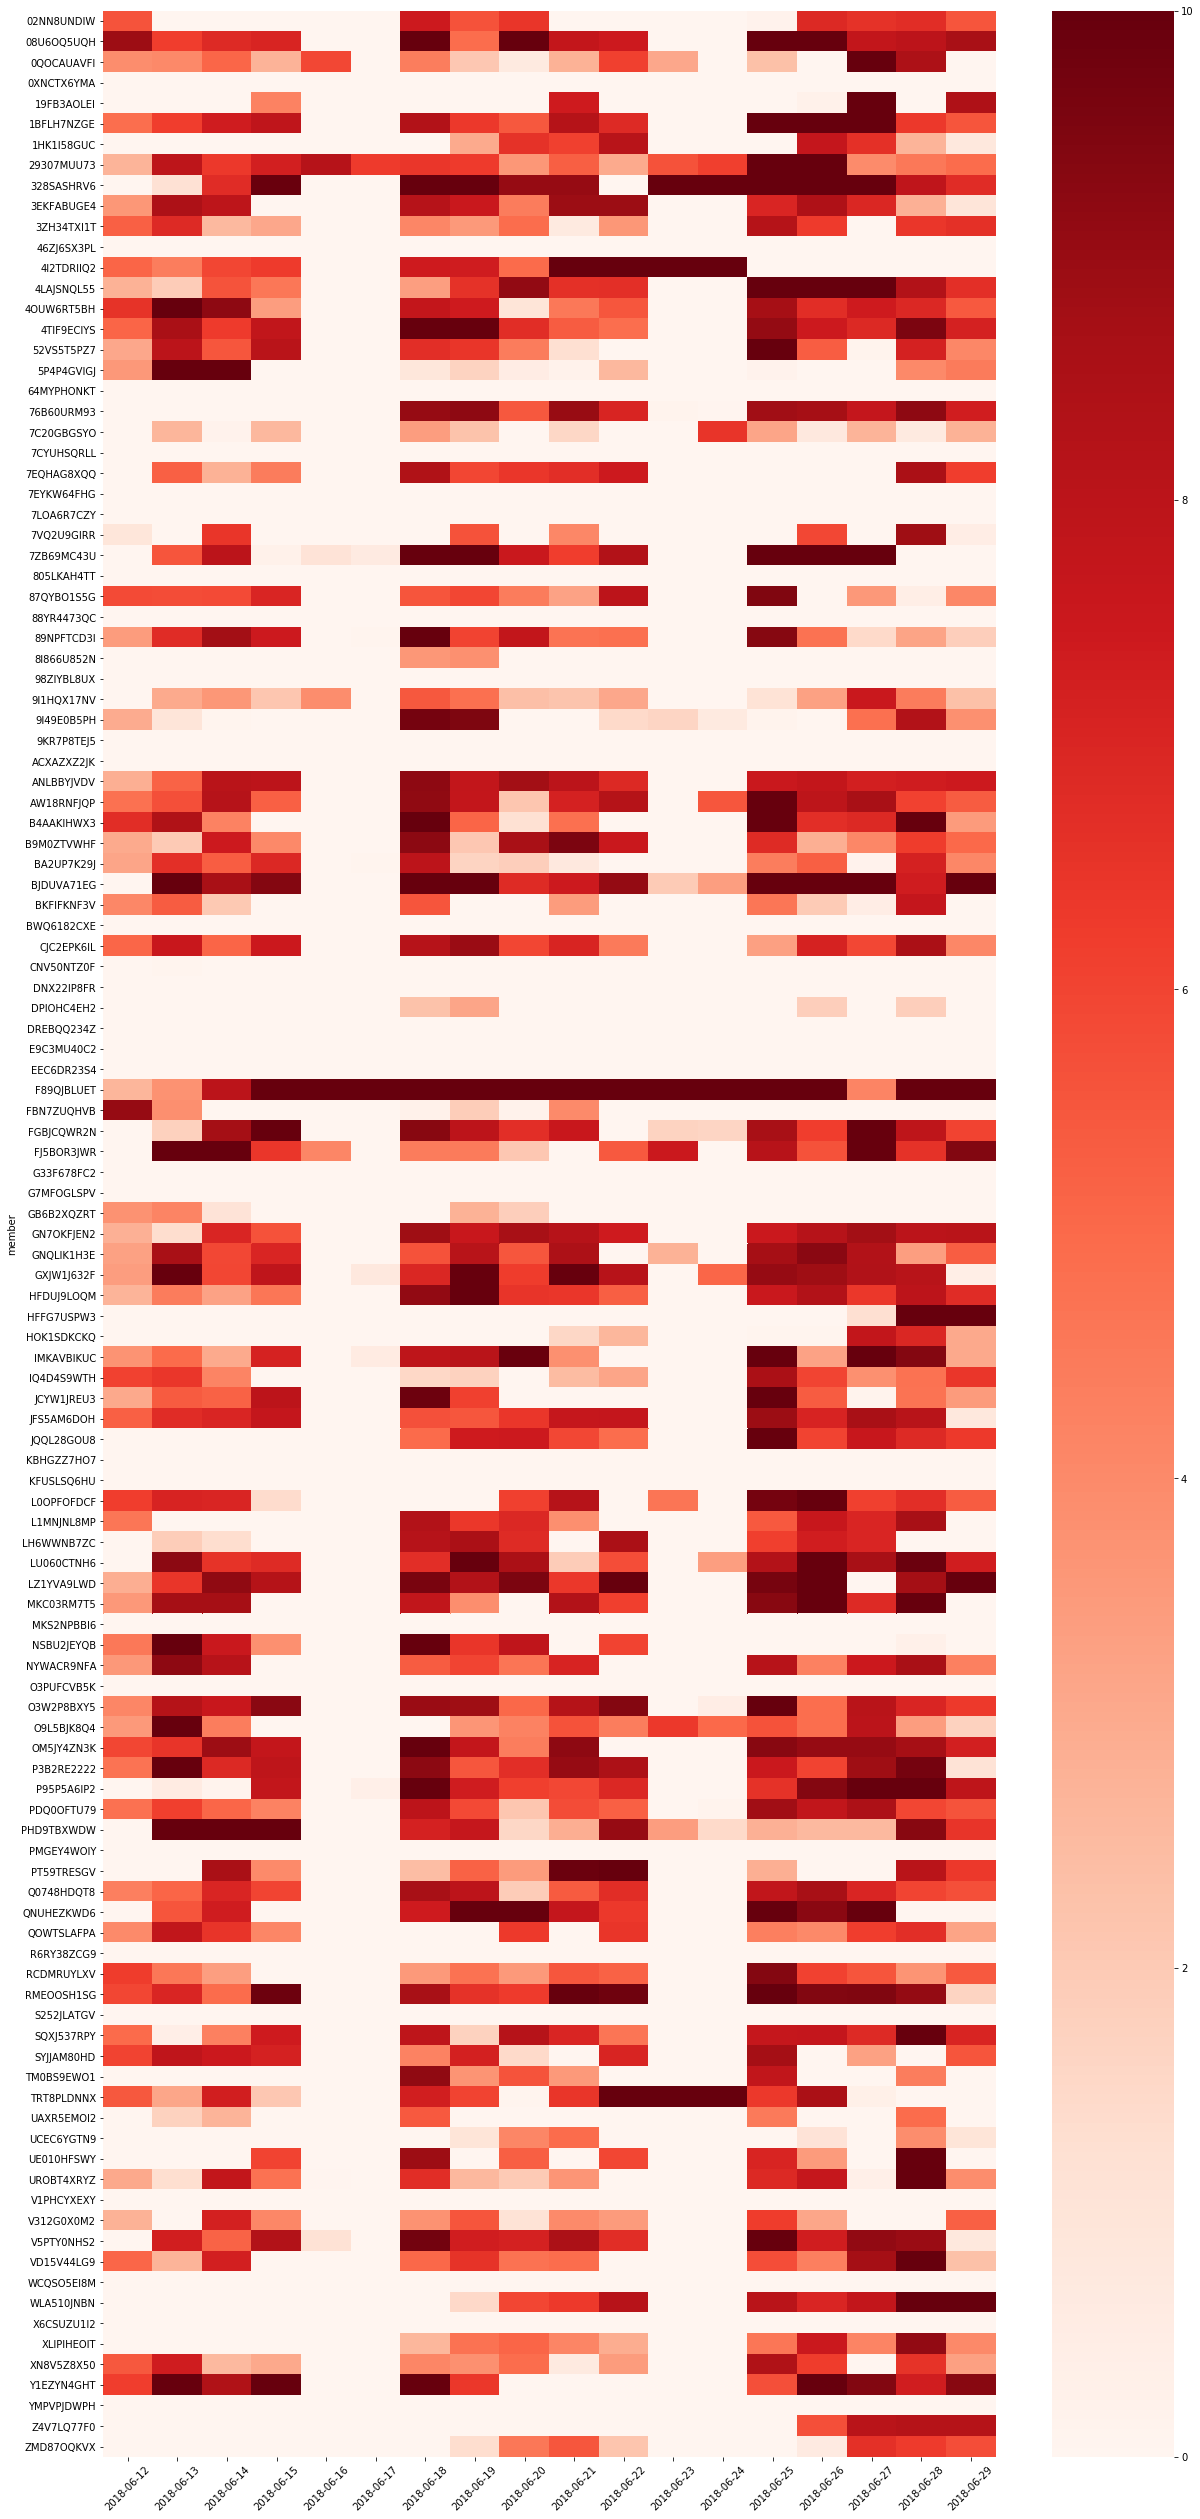

In [12]:
#Creating Period One Heatmap
plt.figure(figsize=(20,45))
sns.heatmap(hours_off_board_period_one,cmap='Reds', vmax = 10, 
            cbar = True)
plt.xticks(rotation = 45)
plt.show()

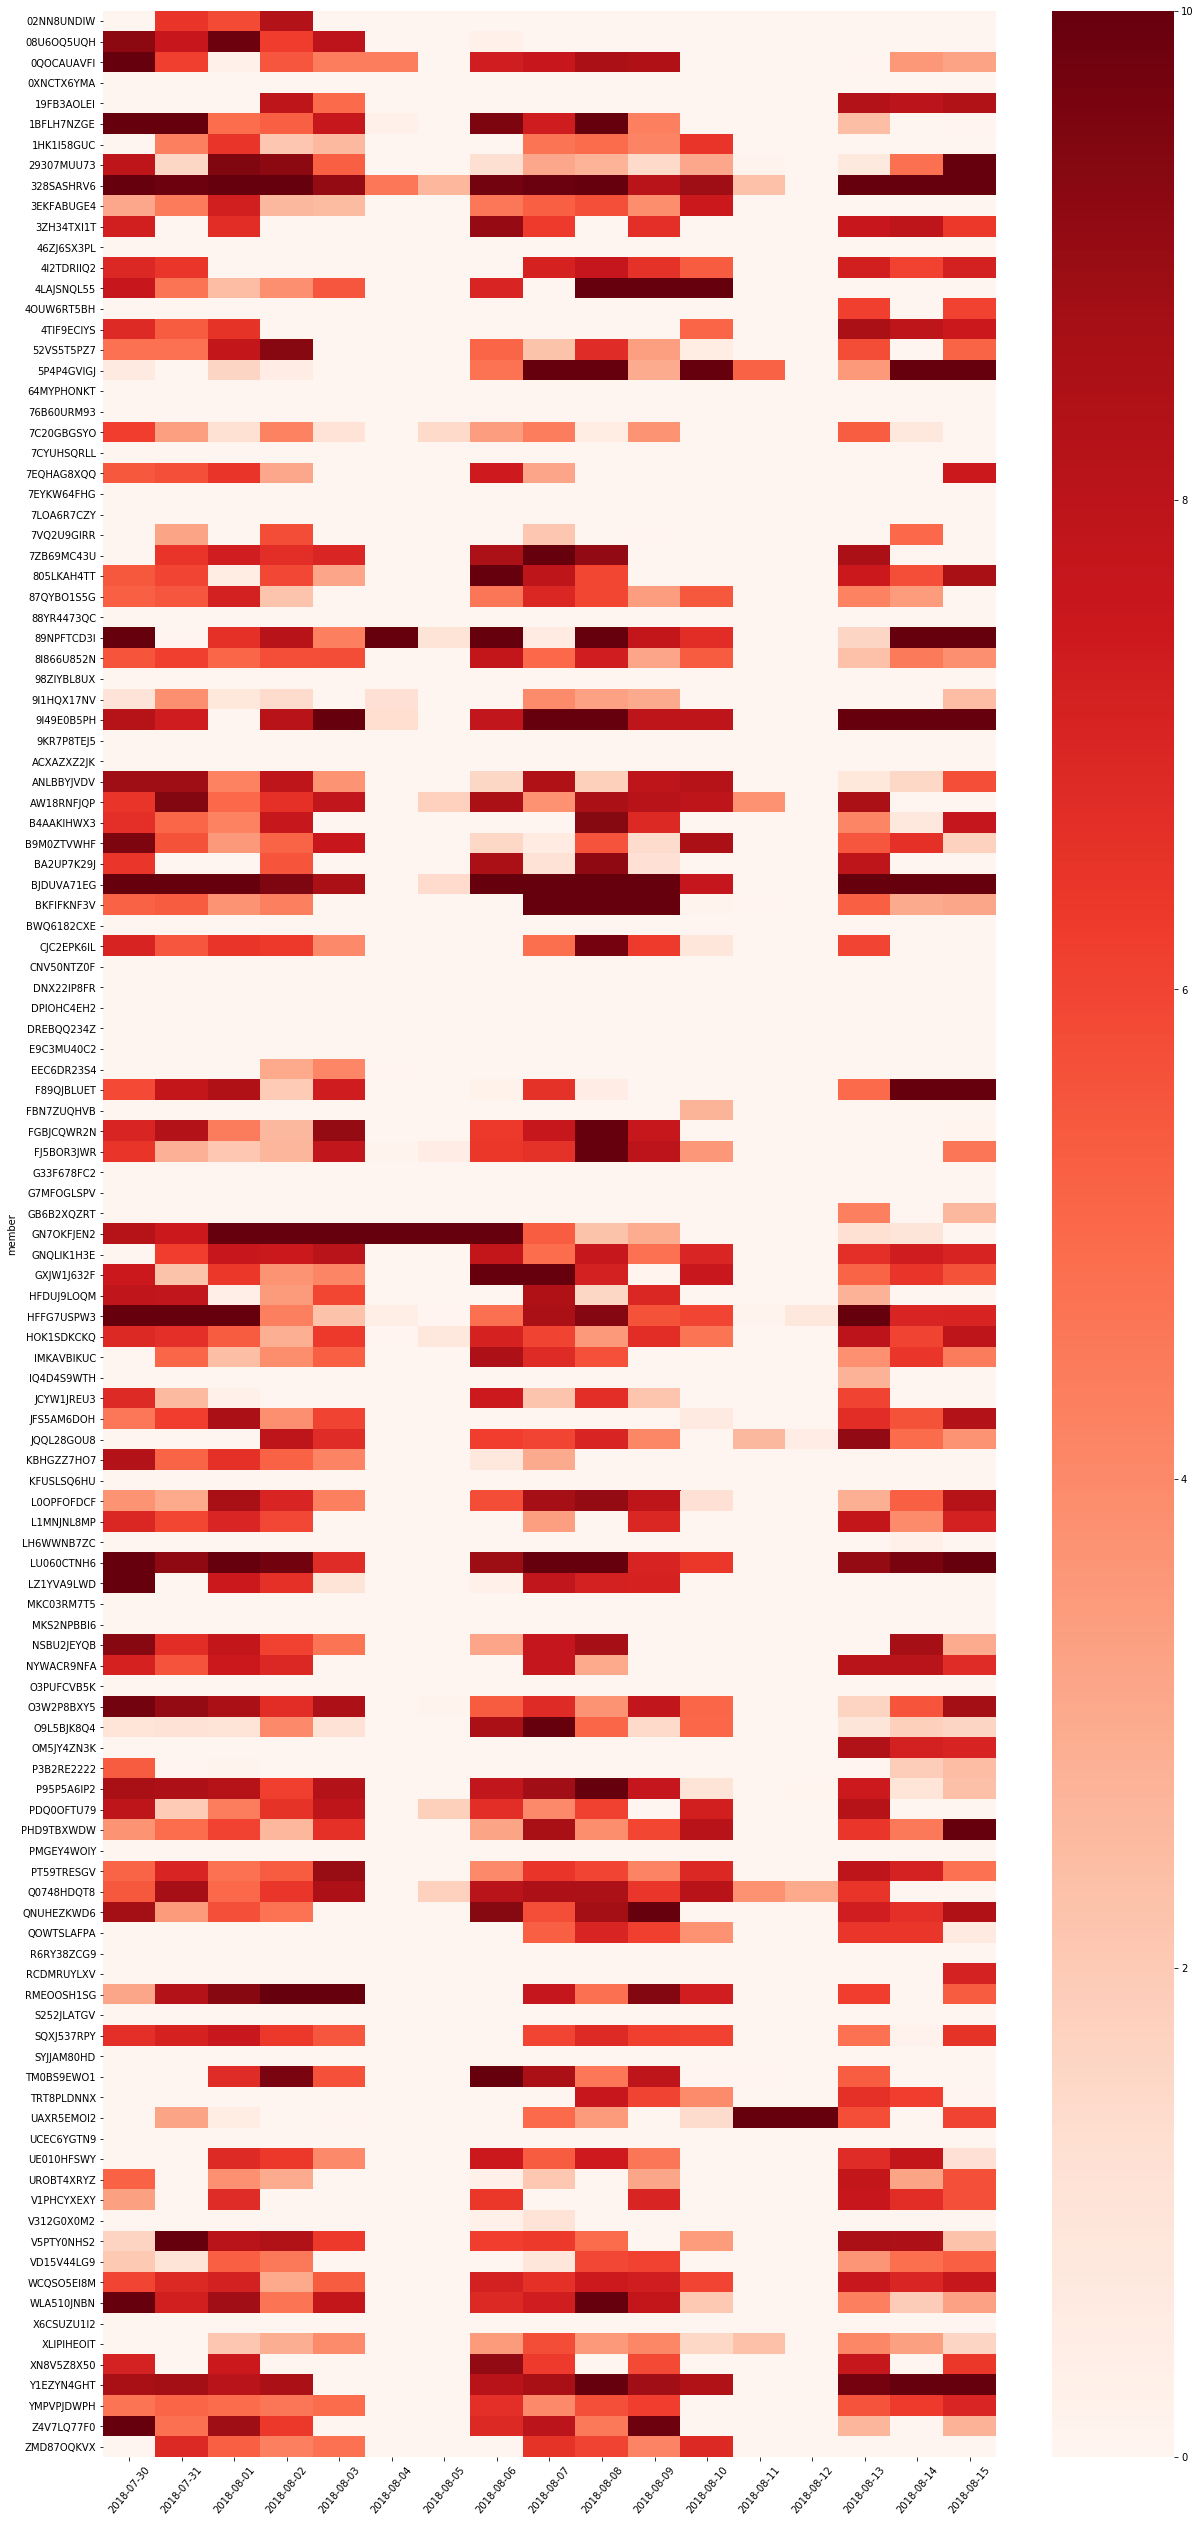

In [13]:
#Creating Period Two Heatmap
plt.figure(figsize=(20,45))
sns.heatmap(hours_off_board_period_two,cmap='Reds', vmax = 10,
            cbar = True)
plt.xticks(rotation = 50)
plt.show()

In [14]:
#Appending to the tables
hours_off_board_period_one['Total_Off_Board'] = hours_off_board_period_one.sum(axis=1)
hours_off_board_period_two['Total_Off_Board'] = hours_off_board_period_two.sum(axis=1)

In [15]:
hours_off_board_period_one.head()

,2018-06-12,2018-06-13,2018-06-14,2018-06-15,2018-06-16,2018-06-17,2018-06-18,2018-06-19,2018-06-20,2018-06-21,2018-06-22,2018-06-23,2018-06-24,2018-06-25,2018-06-26,2018-06-27,2018-06-28,2018-06-29,Total_Off_Board
member,,,,,,,,,,,,,,,,,,,
02NN8UNDIW,5.60,0.00,0.00,0.00,0.0,0.0,7.44,5.66,6.45,0.02,0.00,0.0,0.0,0.19,6.91,6.60,6.74,5.57,51.18
08U6OQ5UQH,8.90,6.19,6.86,7.06,0.0,0.0,12.24,4.89,10.20,7.75,7.45,0.0,0.0,11.38,10.35,7.78,8.00,8.60,117.65
0QOCAUAVFI,3.94,4.05,5.09,2.76,5.9,0.0,4.41,2.10,0.70,2.80,6.13,3.1,0.0,2.31,0.00,10.71,8.44,0.00,62.44
0XNCTX6YMA,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00
19FB3AOLEI,0.00,0.00,0.00,4.22,0.0,0.0,0.00,0.00,0.02,7.39,0.00,0.0,0.0,0.02,0.26,10.68,0.00,8.41,31.00


In [16]:
hours_off_board_period_two.head()

,2018-07-30,2018-07-31,2018-08-01,2018-08-02,2018-08-03,2018-08-04,2018-08-05,2018-08-06,2018-08-07,2018-08-08,2018-08-09,2018-08-10,2018-08-11,2018-08-12,2018-08-13,2018-08-14,2018-08-15,Total_Off_Board
member,,,,,,,,,,,,,,,,,,
02NN8UNDIW,0.00,6.45,5.84,8.26,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,20.55
08U6OQ5UQH,9.25,7.61,9.85,6.22,8.00,0.00,0.0,0.24,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,41.17
0QOCAUAVFI,11.40,6.17,0.26,5.51,4.40,4.41,0.0,7.33,7.61,8.55,8.4,0.0,0.0,0.0,0.04,3.60,3.25,70.93
0XNCTX6YMA,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
19FB3AOLEI,0.00,0.00,0.00,7.96,4.98,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,8.32,8.02,8.34,37.62


Find and individual members hours off the board for the period

In [17]:
member = '328SASHRV6'
hours_off_board_period_two.loc[member]

2018-07-30          10.26
2018-07-31           9.88
2018-08-01          10.83
2018-08-02          10.61
2018-08-03           9.10
2018-08-04           4.58
2018-08-05           2.63
2018-08-06           9.76
2018-08-07           9.92
2018-08-08          10.01
2018-08-09           8.10
2018-08-10           8.84
2018-08-11           2.33
2018-08-12           0.00
2018-08-13          10.58
2018-08-14          10.52
2018-08-15          10.65
Total_Off_Board    138.60
Name: 328SASHRV6, dtype: float64